# Deploy trained TensorFlow models using Amazon SageMaker

본 노트북은 SageMaker TensorFlow Serving 컨테이너에서 실시간으로 추론(prediction)을 수행하는 방법을 보여줍니다.

Amazon SageMaker를 사용하면 개발자 또는 데이터 과학자가 머신 러닝(ML) 모델을 보다 쉽게 구축, 학습 및 배포할 수 있습니다. 
SageMaker가 ML 모델의 전체 수명주기에서 차별화되지 않은 무거운 작업을 완화하도록 설계되었지만, Amazon SageMaker의 기능은 서로 독립적으로 사용할 수도 있습니다. 즉, Amazon SageMaker에서 학습된 모델은 Amazon SageMaker 외부 (또는 모바일 또는 IoT 장치의 클라우드 외부)에서 최적화되고 배포될 수 있습니다. 반대로, Amazon SageMaker는 model zoo나 여러분이 속한 팀의 팀원에게 사전에 학습된 모델을 전달받아 배포하고 호스팅할 수 있습니다.

Amazon SageMaker는 여러분의 모델을 TensorFlow Serving 기반 서버로 배포합니다. 이 서버는 [TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest)의 슈퍼셋(super-set)을 제공합니다.

좀 더 자세히 말하자면, Amazon SageMaker python SDK는 Estimator 클래스의 `deploy()` 메서드를 사용해 SageMaker 모델을 만들고 엔드포인트(endpoint)에 배포 후, 실시간으로 예측 요청을 처리합니다.
입력 데이터와 출력 데이터의 형식은 TensorFlow Serving REST API의 `Predict` 메소드의 요청과 응답의 형식에 직접 대응하고 있습니다. SageMaker의 TensforFlow Serving 엔드포인트는 JSON, 줄 바꿈 JSON 개체 (`'jsons'`또는 `'jsonlines'`), CSV 데이터 등 TensorFlow REST API의 일부가 아닌 추가 입력 형식도 받을 수 있습니다.

Keras/TensorFlow 모델을 배포하기 위해서는, TensorFlow SavedModel 형식으로 모델을 저장해야 합니다. 본 실습은 학습 스크립트에서 이미 ```def save_model(model, output):```로 구현되어 있습니다. 더 많은 정보는 ```save_model``` 함수를 참조해 주세요.

## Deploy a Model that was trained outside of SM 

아래 링크 참고 
https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html

Sagemaker Notebook이 아래 모델에 접근할 권한을 가지고 있어야함. 

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:DeleteObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::*"
            ]
        }
    ]
}
```

S3 bucket에 모델을 tar.gz으로 압축하여 저장 후 해당 경로를 아래에 설정 

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow.serving import Model

model_dir = os.path.join(os.getcwd(), 'model')
os.makedirs(model_dir, exist_ok=True)

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = 'sagemaker-ap-northeast-2-870180618679'
prefix = 'cifar10-2020-07-08-03-12-58-984/output/'
s3_path = 's3://{}/{}'.format(bucket, prefix)
model=sagemaker_session.download_data(model_dir, bucket, os.path.join(prefix, 'model.tar.gz'))


In [2]:
!cd model && tar -xzvf model.tar.gz 


checkpoint-5.h5
checkpoint-3.h5
checkpoint-4.h5
checkpoint-2.h5
1/
1/assets/
1/variables/
1/variables/variables.data-00001-of-00002
1/variables/variables.index
1/variables/variables.data-00000-of-00002
1/saved_model.pb
checkpoint-1.h5


In [3]:
!tree model/

model/
├── 1
│   ├── assets
│   ├── saved_model.pb
│   └── variables
│       ├── variables.data-00000-of-00002
│       ├── variables.data-00001-of-00002
│       └── variables.index
├── checkpoint-1.h5
├── checkpoint-2.h5
├── checkpoint-3.h5
├── checkpoint-4.h5
├── checkpoint-5.h5
├── code
│   └── requirements.txt
└── model.tar.gz

4 directories, 11 files


In [4]:
!mkdir model/code

mkdir: cannot create directory ‘model/code’: File exists


In [5]:
!tree model/

model/
├── 1
│   ├── assets
│   ├── saved_model.pb
│   └── variables
│       ├── variables.data-00000-of-00002
│       ├── variables.data-00001-of-00002
│       └── variables.index
├── checkpoint-1.h5
├── checkpoint-2.h5
├── checkpoint-3.h5
├── checkpoint-4.h5
├── checkpoint-5.h5
├── code
│   └── requirements.txt
└── model.tar.gz

4 directories, 11 files


In [6]:
%%writefile model/code/requirements.txt

jsonlines



Overwriting model/code/requirements.txt


In [7]:
!cat model/code/requirements.txt


jsonlines



In [8]:
!rm model/model.tar.gz
!cd model/ && tar -zcvf  model.tar.gz .

./
./checkpoint-2.h5
./checkpoint-3.h5
./checkpoint-4.h5
./checkpoint-5.h5
./1/
./1/saved_model.pb
./1/assets/
./1/variables/
./1/variables/variables.index
./1/variables/variables.data-00000-of-00002
./1/variables/variables.data-00001-of-00002
./checkpoint-1.h5
./code/
./code/requirements.txt
tar: .: file changed as we read it


In [9]:
model_data = sagemaker_session.upload_data('model/model.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))

In [10]:

# The "Model" object doesn't create a SageMaker Model until a Transform Job or Endpoint is created.
#model_data='s3://sagemaker-ap-northeast-2-870180618679/cifar10-2020-07-01-02-47-56-774/output/model.tar.gz'
model = Model(model_data=model_data,
                                 role=role,
                                 framework_version='2.1',
                                 sagemaker_session=sagemaker_session)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

아래 코드 셀을 통해 SageMaker 엔드포인트(endpoint)를 생성합니다. 배포 인스턴스를 시작하기 때문에 약 7분에서 10분의 시간이 소요됩니다. 

## Make some predictions

엔드포인트(endpoint)가 정상적으로 작동하는지 검증하기 위해, 여러분께서는 랜덤 데이터를 생성하여 예측(prediction)을 수행합니다.

In [11]:
# Creating fake prediction data
import numpy as np
data = np.random.randn(1, 32, 32, 3)

print("Predicted class is {}".format(np.argmax(predictor.predict(data)['predictions'])))

Predicted class is 3


### Calculating accuracy and create a confusion matrix based on the test dataset

엔드포인트가 예상대로 작동하는 것을 확인했습니다. 이제 예측을 위해 테스트 데이터셋을 사용하고 모델 정확도(accuracy)를 계산합니다.

In [12]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
datagen = ImageDataGenerator()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def predict(data):
    predictions = predictor.predict(data)['predictions']
    return predictions

Using TensorFlow backend.



170500096/170498071 [==============================] - 21s 0us/step


In [13]:
%%time
batch_size = 128
predicted = []
actual = []
batches = 0
for data in datagen.flow(x_test, y_test, batch_size=batch_size):
    for i,prediction in enumerate(predict(data[0])):
        predicted.append(np.argmax(prediction))
        actual.append(data[1][i][0])
    batches += 1
    if batches >= len(x_test) / batch_size:
        break

CPU times: user 22.3 s, sys: 1.01 s, total: 23.3 s
Wall time: 29.6 s


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_pred=predicted,y_true=actual)
display('Average accuracy: {}%'.format(round(accuracy*100,2)))

'Average accuracy: 62.02%'

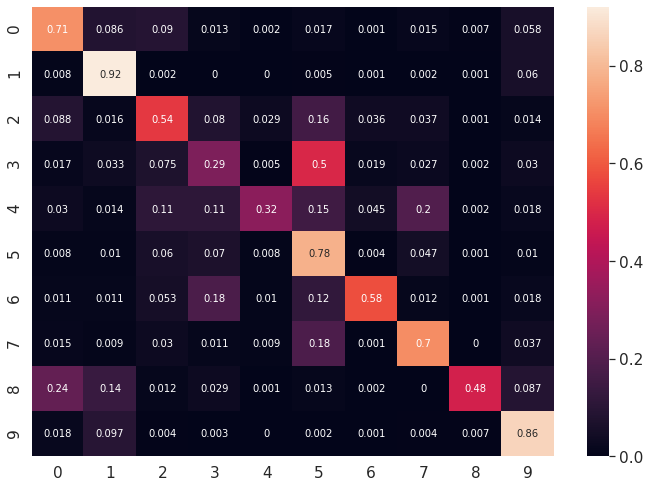

In [15]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred=predicted,y_true=actual)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={'figure.figsize': (11.7,8.27)})
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 10})# font size

히트맵을 사용하여 각 레이블마다의 accuracy를 계산할 수 있습니다.

# Cleaning up
본 워크샵에서 사용한 리소스에 대해 여러분의 AWS 계정에 과금되지 않도록 하려면 SageMaker Endpoint를 삭제해야 합니다.

In [16]:
sagemaker_session.delete_endpoint(predictor.endpoint)